run the install script in the Anaconda terminal to enable the libraries below: <br>
> missingno: conda install -c conda-forge missingno <br>
> tensorFlow: conda install -c conda-forge tensorflow <br>


First we need to get the dataset from kaggle to be able to work with it. <br>
Below are we few cells that manage the downloading and preparation of the kaggle dataset.

In [1]:
# Imports dependingcies.
import pandas as pd
import matplotlib.pyplot as plot
import missingno
import numpy as np
from math import floor
from scipy.stats import zscore

In [2]:
# Import of kaggle data with panda.

impTrain = pd.read_csv('./data/train.csv')
impTest = pd.read_csv('./data/test.csv')
impSample = pd.read_csv('./data/sample_submission.csv')

In [3]:
# Combine data from kaggle into a single variable.
mergeTestSample = pd.merge(impTest, impSample, on='Id')
allData = impTrain.append(mergeTestSample)

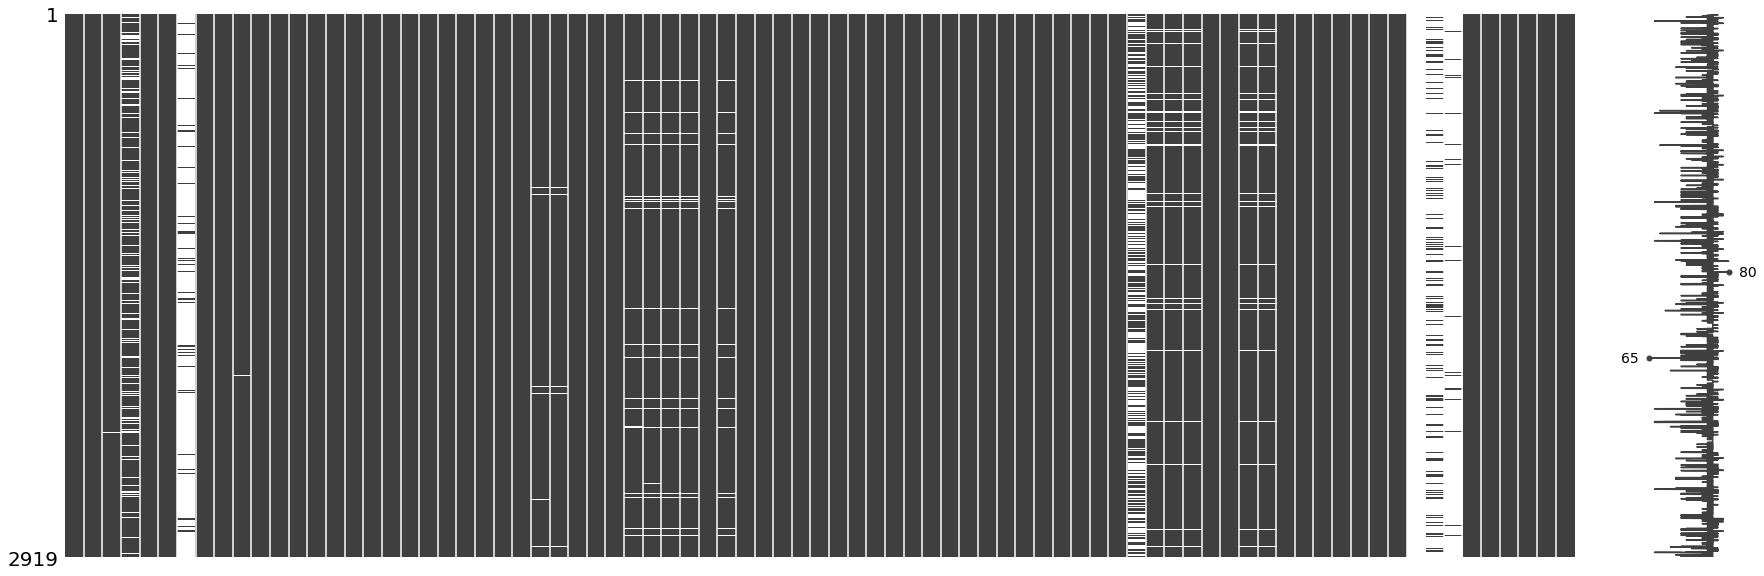

In [4]:
# Display the kaggle data.

missingno.matrix(allData, figsize = (30,10))

Next we need to clean up the dataset. <br>
This is done by removing features with a lot of missing values. <br>
Than we fill the missing values or nan values with the mean or most common values depending on the datatype. <br>
Afterwards we break catagories down into features by one-hot encoding. <br>

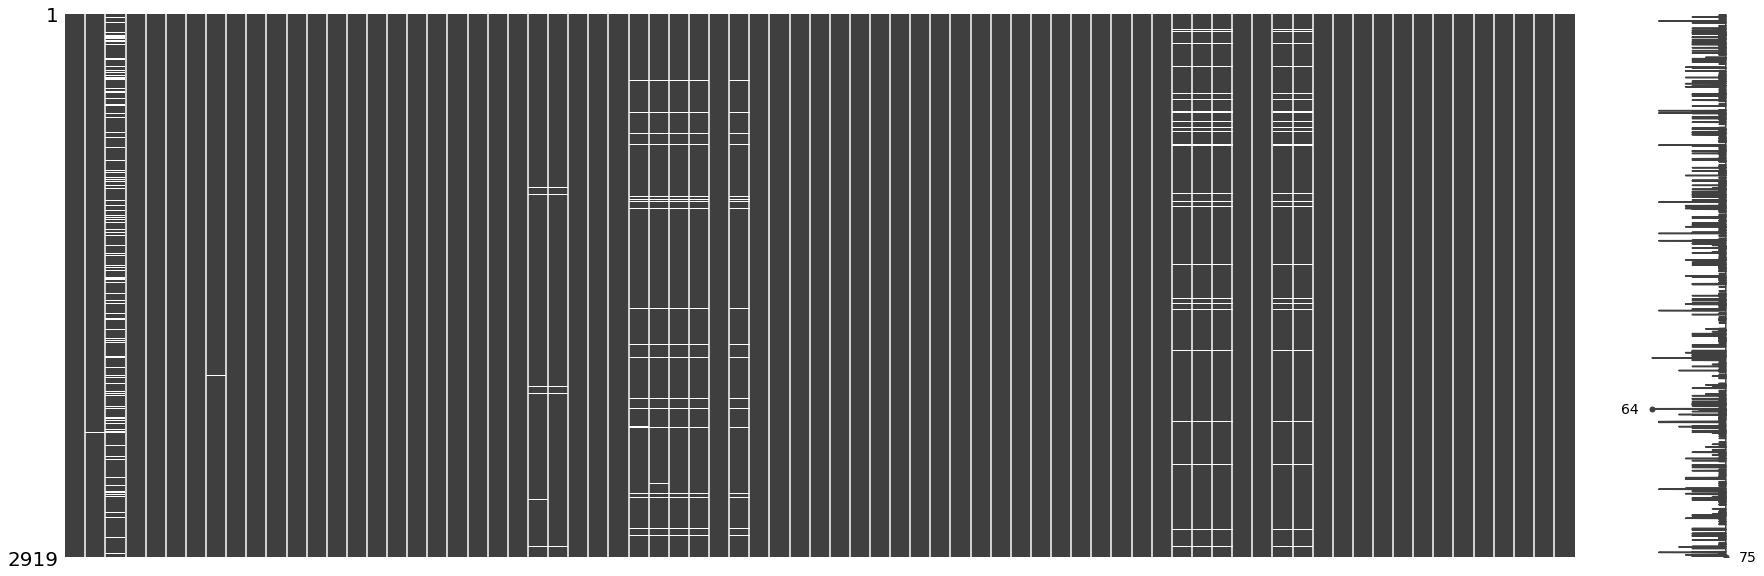

In [5]:
# A few features are excluded because the features are missing to many values.
# Excluded features: Alley, FireplaceQu, PoolQC, Fence and MiscFeature.
kaggleData = allData.drop(["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature", "Id"], axis=1)

missingno.matrix(kaggleData, figsize = (30,10))

In [6]:
# Defines a function to fill missing values in a given dataSet.
def fill_missing_or_nan_values(dataSet):
    fill_with = 0
    
    # Get the most common element by using size(), which returns the element and how common it is
    for column in dataSet:
        
        # Check if the column is an object, float64 or int64
        is_it_float = (dataSet[column].dtype == np.float64)
        is_it_int = (dataSet[column].dtype == np.int64)
        
        # If it is an object, find the most common element and fill missing and NaN values
        if(not is_it_float and not is_it_int):
            fill_with = dataSet[column].mode().item()
                    
        # If it is either a float64 or int64, then calculate the mean and fill missing and NaN values            
        else:
            if is_it_float:
                fill_with = np.nanmean(dataSet[column], dtype=np.float64)
            if is_it_int:
                fill_with = np.nanmean(dataSet[column], dtype=np.int64)
        
        # Fill the values in our dataset
        dataSet[column] = dataSet[column].fillna(fill_with)
        fill_with = 0

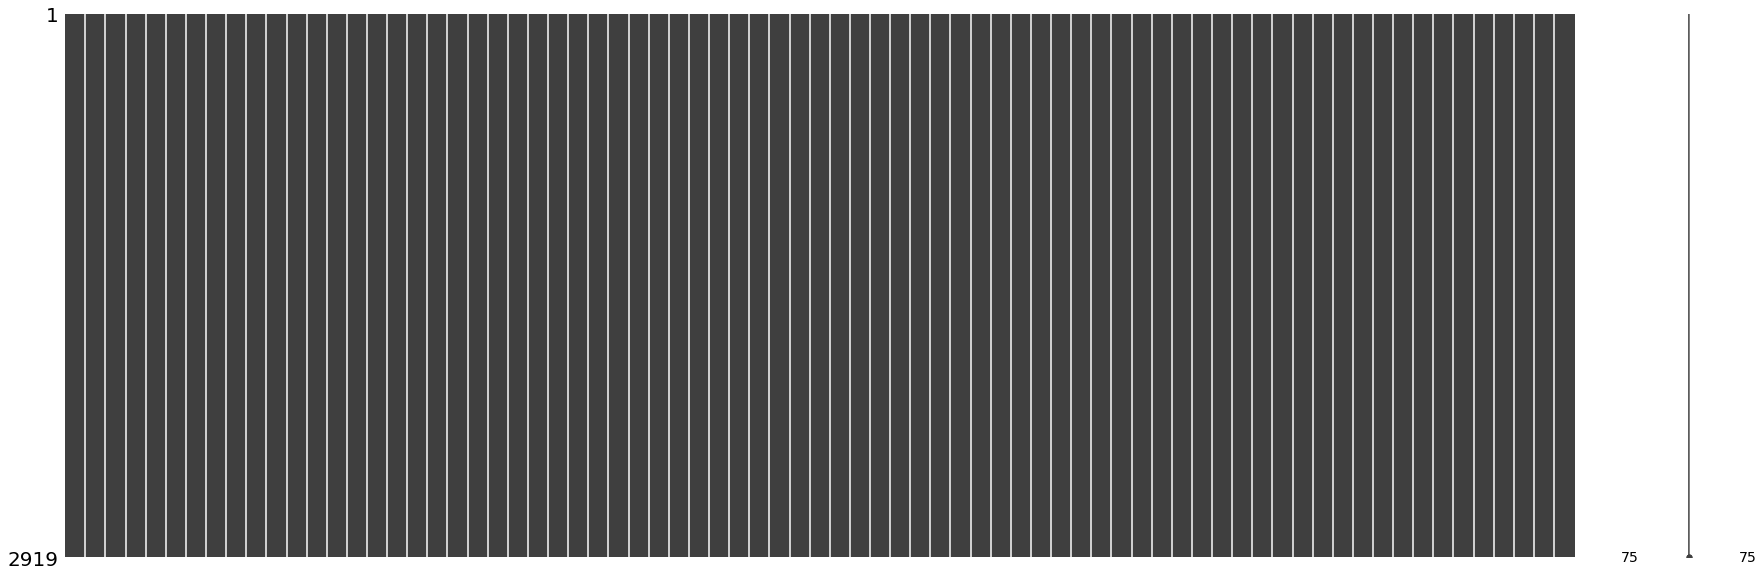

In [7]:
# Fill missing or nan values by the use of the "fill_missing_or_nan_values" function.
fill_missing_or_nan_values(kaggleData)

missingno.matrix(kaggleData, figsize = (30,10))

In [8]:
# Break categories into features by one hot encoding.
# Before encoding.
kaggleData.head(3)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500.0


In [9]:
# After encoding.
kaggleData = pd.get_dummies(kaggleData, prefix_sep='_', drop_first=True)
kaggleData.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [10]:
#Splits the data set into features and salePrice.
kaggleX = kaggleData.drop(['SalePrice'],axis=1)
kaggleY = kaggleData["SalePrice"]

In [11]:
# Normalization by using zscore
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
normKaggleX = zscore(kaggleX)

In [12]:
# Defines the fraction between training and test sets.
# Train_fraction needs to be set between 0 and 1 for a ratio between the correspoding sizes.
train_fraction = 0.82

splitIndex = int(floor(len(kaggleData) * train_fraction))
x_train = normKaggleX[:splitIndex]
y_train = kaggleY[:splitIndex]
x_test = normKaggleX[splitIndex:]
y_test = kaggleY[splitIndex:]

In [13]:
# Print the size of the training and testing sets.
print("Training set size: " + str(len(x_train)))
print("Testing set size: " + str(len(x_test)))

Training set size: 2393
Testing set size: 526


In [14]:
# TensorFlow and tf.keras
# https://becominghuman.ai/creating-your-own-neural-network-using-tensorflow-fa8ca7cc4d0e
# https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

print("TensorFlow v." + tf.__version__)

TensorFlow v.1.13.1


Using TensorFlow backend.


In [15]:
# building a model

model = Sequential()

columns = x_train.shape[1]

model.add(Dense(64, activation='relu', input_shape=(columns,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(
    loss='mean_squared_error', 
    optimizer = 'adam'
    , metrics=['accuracy', 'mean_squared_error']
)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.fit(x_train, y_train, epochs=200, batch_size=16,
          validation_data = (x_test, y_test), callbacks = [EarlyStopping(patience = 3)]) 

Instructions for updating:
Use tf.cast instead.
Train on 2393 samples, validate on 526 samples
Epoch 1/200
2393/2393 [==============================] - 1s 303us/step - loss: 36238952397.5061 - acc: 0.0000e+00 - mean_squared_error: 36238952397.5061 - val_loss: 32954757306.8897 - val_acc: 0.0000e+00 - val_mean_squared_error: 32954757306.8897
Epoch 2/200
2393/2393 [==============================] - 0s 129us/step - loss: 35361772732.7104 - acc: 0.0000e+00 - mean_squared_error: 35361772732.7104 - val_loss: 31571419167.1483 - val_acc: 0.0000e+00 - val_mean_squared_error: 31571419167.1483
Epoch 3/200
2393/2393 [==============================] - 0s 120us/step - loss: 31794085301.7568 - acc: 0.0000e+00 - mean_squared_error: 31794085301.7568 - val_loss: 27818855466.8289 - val_acc: 0.0000e+00 - val_mean_squared_error: 27818855466.8289
Epoch 4/200
2393/2393 [==============================] - 0s 135us/step - loss: 25128037699.9315 - acc: 0.0000e+00 - mean_squared_error: 25128037699.9315 - val_loss:

2393/2393 [==============================] - 0s 124us/step - loss: 2213358249.1868 - acc: 0.0000e+00 - mean_squared_error: 2213358249.1868 - val_loss: 3670962201.3080 - val_acc: 0.0000e+00 - val_mean_squared_error: 3670962201.3080
Epoch 34/200
2393/2393 [==============================] - 0s 135us/step - loss: 2185561243.0656 - acc: 0.0000e+00 - mean_squared_error: 2185561243.0656 - val_loss: 3640649013.5361 - val_acc: 0.0000e+00 - val_mean_squared_error: 3640649013.5361
Epoch 35/200
2393/2393 [==============================] - 0s 130us/step - loss: 2159911306.0025 - acc: 0.0000e+00 - mean_squared_error: 2159911306.0025 - val_loss: 3614904072.7605 - val_acc: 0.0000e+00 - val_mean_squared_error: 3614904072.7605
Epoch 36/200
2393/2393 [==============================] - 0s 128us/step - loss: 2134390879.6389 - acc: 0.0000e+00 - mean_squared_error: 2134390879.6389 - val_loss: 3583297331.5894 - val_acc: 0.0000e+00 - val_mean_squared_error: 3583297331.5894
Epoch 37/200
2393/2393 [=============

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                14912     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 19,137
Trainable params: 19,137
Non-trainable params: 0
_________________________________________________________________


In [19]:
print(model.evaluate(x_test,y_test,batch_size=32))

526/526 [==============================] - 0s 38us/step
[3370459050.3422055, 0.0, 3370459050.3422055]


layers.Dense(64, activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
layers.Dense(64, activation=tf.nn.relu),
layers.Dense(1)]

# sets hyperparameters
training_epochs = 500
n_neurons_in_h1 = 60
n_neurons_in_h2 = 60
learning_rate = 0.01

# Define normalization function.
stats = x_train.describe()
def normalize(dataSet):
    return (dataSet - stats.mean) / stats.std